## Import libraries

In [1]:
!pip install gensim
!pip install jieba
!pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.5 MB/s 
     |████████████████████████████████| 581 kB 41.1 MB/s 
     |████████████████████████████████| 235 kB 38.6 MB/s 
     |████████████████████████████████| 965 kB 42.7 MB/s 


In [2]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 4.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=0a8bfd93a7df6660592b90d900daa7b0a2d66471eed32728b634f5912840fd0a
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [5]:
%cd '/content/gdrive/My Drive/LDS0_K276_BuiThiHuong/Topic3'

/content/gdrive/My Drive/LDS0_K276_BuiThiHuong/Topic3


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import jieba
import re
import time

# Step 1: BUSINESS UNDERSTANDING

Chưa có hệ thống Recommendation System 
* Mục tiêu/ vấn đề: Xây dựng Recommendation System 
cho một hoặc một số nhóm hàng hóa trên tiki.vn giúp đề 
xuất và gợi ý cho người dùng/ khách hàng. 
* Xây dựng 
các mô hình đề xuất:
1. Content-based filtering
2. Collaborative filtering

# PROBLEM 1: CONTENT-BASED FILTERING

# Step 2: DATA UNDERSTANDING

## Read data

In [7]:
df_product = pd.read_csv('ProductRaw.csv')

In [8]:
# shape
df_product.shape

(4404, 10)

In [9]:
# drop duplicate
df_product = df_product.drop_duplicates()

In [ ]:
# info
df_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4373 entries, 0 to 4403
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      4373 non-null   int64  
 1   name         4373 non-null   object 
 2   description  4370 non-null   object 
 3   rating       4373 non-null   float64
 4   price        4373 non-null   int64  
 5   list_price   4373 non-null   int64  
 6   brand        4373 non-null   object 
 7   group        4373 non-null   object 
 8   url          4373 non-null   object 
 9   image        4373 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 375.8+ KB


In [ ]:
# pandas profiling


In [ ]:
df_product.head()

,item_id,name,description,rating,price,list_price,brand,group,url,image
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...
3,57440329,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,THÔNG TIN CHI TIẾT\nThương hiệu Acome\nXuất xứ...,4.7,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...
4,38458616,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.8,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...


## EDA

In [14]:
for i in df_product.columns:
  print(df_product[i][0])
  print('-'*20)

48102821
--------------------
Tai nghe Bluetooth Inpods 12 - Cảm biến vân tay, chống nước,màu sắc đa dạng- 5 màu sắc lựa chọn
--------------------
THÔNG TIN CHI TIẾT
Dung lượng pin 300
Thời gian pin - Thời gian nghe nhạc liên tục từ 2.5-4h - Thời gian sạc đầy chỉ khoảng 60p - Thời gian chờ lên tới 140 giờ
Bluetooth 5
Thương hiệu OEM
Xuất xứ thương hiệu Trung Quốc
Độ nhạy cảm biến vân tay
Model i12
Loại Jack cắm USB Cable
Trọng lượng 300g
Thời gian sử dụng
- Thời gian nghe nhạc liên tục từ 2.5-4h
SKU 4096608751631
MÔ TẢ SẢN PHẨM
INPOD 12 là phiên bản nâng cấp mới nhất , tai nghe Bluetooth 5.0 có thiết kế tỉ lệ chuẩn 1:1 với tai Airpod chính hãng
Lược bỏ nút bấm trên thân tai thay vào đó là nút cảm ứng sử dụng dễ dàng và thuận tiện hơn
Thao tác nhận cuộc gọi đến, chuyển nhạc...một cách dễ dàng chỉ bằng 1 chạm
Bluetooth 5.0 mới nhất cho kết nối vô cùng ổn định
- Bluetooth 5.0 mới nhất cho kết nối vô cùng ổn định
- 2 tai nghe tự kết nối với nhau khi được lấy ra từ dock sạc
- Chất âm và thờ

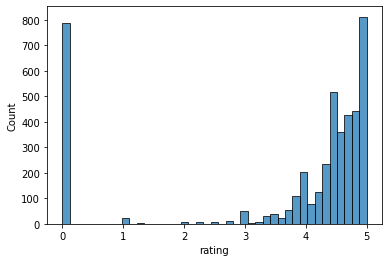

In [28]:
# rating
sns.histplot(df_product['rating'])

* rating scores are from 0 to 5.
* Almost rating scores are from 4 to 5.

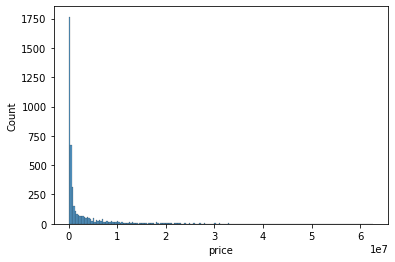

In [29]:
# price
sns.histplot(df_product['price'])

In [20]:
# product group
df_product_group = df_product['group'].str.split('/', expand=True)

In [24]:
lst_col_names = []
for i in df_product_group.columns:
  col_name = 'group_l' + str(i)
  lst_col_names.append(col_name)

df_product_group.columns = lst_col_names

In [30]:
df_product_group['group_l1'].value_counts()

Phụ Kiện Máy Ảnh, Máy Quay                       403
Âm thanh & Phụ kiện Tivi                         396
Phụ Kiện Điện Thoại và Máy Tính Bảng             351
Phụ kiện máy tính và Laptop                      322
Camera Giám Sát                                  286
Thiết Bị Âm Thanh và Phụ Kiện                    277
Thiết Bị Văn Phòng - Thiết Bị Ngoại Vi           231
Thiết Bị Mạng                                    214
Thiết Bị Lưu Trữ                                 203
Linh Kiện Máy Tính - Phụ Kiện Máy Tính           172
Tivi                                             148
Điện thoại Smartphone                            122
Tủ lạnh                                          121
Điện thoại phổ thông                             112
Máy giặt                                          93
Điện thoại bàn                                    90
Camera Hành Trình - Action Camera và Phụ Kiện     83
Máy lạnh - Máy điều hòa                           82
Thiết Bị Đeo Thông Minh và Phụ Kiện           

# Step 3: DATA PREPARATION

### Create "name_desc" feature

In [ ]:
df_product['name_desc'] = df_product['name'].fillna('') + '. ' + df_product['description'].fillna('')

In [ ]:
df_product['name_desc'][0]

'Tai nghe Bluetooth Inpods 12 - Cảm biến vân tay, chống nước,màu sắc đa dạng- 5 màu sắc lựa chọn. THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời gian pin - Thời gian nghe nhạc liên tục từ 2.5-4h - Thời gian sạc đầy chỉ khoảng 60p - Thời gian chờ lên tới 140 giờ\nBluetooth 5\nThương hiệu OEM\nXuất xứ thương hiệu Trung Quốc\nĐộ nhạy cảm biến vân tay\nModel i12\nLoại Jack cắm USB Cable\nTrọng lượng 300g\nThời gian sử dụng\n- Thời gian nghe nhạc liên tục từ 2.5-4h\nSKU 4096608751631\nMÔ TẢ SẢN PHẨM\nINPOD 12 là phiên bản nâng cấp mới nhất , tai nghe Bluetooth 5.0 có thiết kế tỉ lệ chuẩn 1:1 với tai Airpod chính hãng\nLược bỏ nút bấm trên thân tai thay vào đó là nút cảm ứng sử dụng dễ dàng và thuận tiện hơn\nThao tác nhận cuộc gọi đến, chuyển nhạc...một cách dễ dàng chỉ bằng 1 chạm\nBluetooth 5.0 mới nhất cho kết nối vô cùng ổn định\n- Bluetooth 5.0 mới nhất cho kết nối vô cùng ổn định\n- 2 tai nghe tự kết nối với nhau khi được lấy ra từ dock sạc\n- Chất âm và thời lượng pin được cải thiện tố

In [ ]:
# check na, null
df_product.isna().sum()

item_id        0
name           0
description    3
rating         0
price          0
list_price     0
brand          0
group          0
url            0
image          0
name_desc      0
dtype: int64

In [ ]:
df_product[df_product['description'].isnull()]

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_desc
1424,75831435,Camera Ip EZVIZ C8C hồng ngoại không dây Full ...,NaN,0.0,1465000,3200000,EZVIZ,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-ip-ezviz-c8c-hong-ngoai-khong-d...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Camera Ip EZVIZ C8C hồng ngoại không dây Full ...
2535,11607917,Màn Hình LED LG 27MK600M-B 27 inch Full HD (19...,NaN,0.0,4200000,5500000,LG,Laptop - Máy Vi Tính - Linh kiện/Thiết Bị Văn ...,https://man-hinh-led-lg-27mk600m-b-27-inch-ful...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Màn Hình LED LG 27MK600M-B 27 inch Full HD (19...
3294,16608046,Điện Thoại Di Động Forme A5 - Hãng phân phối c...,NaN,3.7,335000,389000,Forme,Điện Thoại - Máy Tính Bảng/Điện thoại phổ thông,https://dien-thoai-di-dong-forme-a5-hang-phan-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Điện Thoại Di Động Forme A5 - Hãng phân phối c...


In [ ]:
# drop na
# df_product = df_product.dropna()

### Extract emojicons

In [ ]:
# create function to extract emojicons
def extract_emojis(doc):
  lst_emojis = []
  for i in doc:
    if i in emoji.UNICODE_EMOJI['en']: lst_emojis.append(i)
  return lst_emojis

# extract emojicons from this dataset
lst_emojis = []
for i in document:
  emojis = extract_emojis(i)
  lst_emojis = lst_emojis + emojis
lst_emojis = set(lst_emojis)

In [ ]:
lst_emojis

{'®', '™'}

In [ ]:
# # open existed emojicons
# file = open('lib/files/emojicon.txt', 'r', encoding="utf8")
# emoji_lst = file.read().split('\n')
# emoji_list = []
# for line in emoji_lst:
#     key, value = line.split('\t')
#     emoji_list.append(key)
# file.close()

In [ ]:
# # filter emojicons that's not in existed emojicons
# lst_emoji_final = []
# for i in lst_emojis:
#   if not i in emoji_list: lst_emoji_final.append(i)

In [ ]:
# save filtered to csv file
pd.DataFrame(lst_emojis).to_csv('outputs/lst_emoji.csv', index=False)

* The documents almost don't have emojicons.
* We don't need to convert emojicons to words.

### Text cleaning

In [ ]:
document = df_product['name_desc']

In [ ]:
# # load edited emojicon
# file = open('lib/files/emojicon.txt', 'r', encoding="utf8")
# emoji_lst = file.read().split('\n')
# file.close()

# emoji_dict = {}
# lst_key = []
# lst_value = []
# for line in emoji_lst:
#   key, value = line.split('\t')
#   lst_key.append(key)
#   lst_value.append(value)
#   emoji_dict[key] = str(value)

In [ ]:
STOP_WORD_FILE = 'vietnamese-stopwords.txt'
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

In [ ]:
# load additional_stopwords
file = open('additional_stopwords.txt', 'r', encoding="utf8")
lst_stopwords = file.read().split('\n')
file.close()

In [ ]:
lst_stopwords = list(set(stop_words + lst_stopwords))

In [ ]:
lst_spec_symbol = ['~','`','!','@','#','$','%','^','&','*','(',')','-','=','+',   '[','{','}','}','\\','|',';',':','"',     ',','<','.','>','/','?']

In [ ]:
lst_find_words = ['không ','ko ','chả ','chẳng ']
lst_replace_words = ['không_','ko_','chả_','chẳng_']

In [ ]:
start_time = time.time()

lst_document = []
for doc in document:
  doc = doc.lower()

# # replace emojicons
#   for i in range(len(lst_key)):
#     doc = doc.replace(lst_key[i], ' '+lst_value[i])
#   for j in doc:
#     if j in emoji.UNICODE_EMOJI['en']: 
#       doc = doc.replace(j, '')



# word tokenize: sạch sẽ => sạch_sẽ
  doc = word_tokenize(doc, format='text')

# remove special symbols
  rx = '[' + re.escape(''.join(lst_spec_symbol)) + ']' 
  doc = re.sub(rx, '', doc)

  doc = doc.replace('  ',' ')
  doc = doc.replace(' _',' ')
  doc = doc.replace('_ ',' ')

# remove number
  lst_words = []
  for j in doc.split(' '):
    j = re.sub('[0-9]+','', j)
    lst_words.append(j)
  doc =  ' '.join(lst_words)  

# replace 'không ' to 'không_' co link words, v.v...
  for i in range(len(lst_find_words)):
    doc = doc.replace(lst_find_words[i], lst_replace_words[i]) 

# remove stop_words
  lst_words = []
  for j in doc.split(' '):
    if j in lst_stopwords:  pass
    else:   lst_words.append(j)
  doc =  ' '.join(lst_words)  
   

  lst_document.append(doc)  
    
end_time = time.time()

In [ ]:
d = (end_time - start_time)/60
d

3.1242167353630066

In [ ]:
lst_document[:5]

['tai bluetooth inpods cảm_biến vân chống màu_sắc đa_dạng màu_sắc lựa_chọn thông_tin chi_tiết dung_lượng pin pin nhạc liên_tục h sạc p chờ bluetooth thương_hiệu oem xuất_xứ thương_hiệu trung_quốc độ nhạy_cảm_biến vân model jack cắm usb cable trọng_lượng g nhạc liên_tục h sku mô_tả sản_phẩm inpod phiên_bản nâng_cấp tai_nghe bluetooth thiết_kế tỉ_lệ chuẩn tai airpod hãng lược_bỏ nút bấm thân tai thay nút cảm_ứng dễ_dàng thuận_tiện thao_tác nhạc dễ_dàng chạm bluetooth kết_nối vô_cùng ổn_định bluetooth kết_nối vô_cùng ổn_định tai kết_nối dock sạc chất âm thời_lượng pin cải_thiện tối_ưu dock sạc tiện_lợi sạc pin tai_nghe thiết_bị tương_thích thiết_bị bluetooth xiaomi samsung apple huawei oppo vivo lenovo tablet v v nhạc liên_tục h sạc p chờ giá sản_phẩm tiki bao_gồm thuế luật hiện_hành tuỳ sản_phẩm phương_thức địa_chỉ giao hàng phát_sinh chi_phí phí vận_chuyển phụ_phí hàng cồng_kềnh',
 'tai bluetooth không_dây f true wireless dock sạc led báo pin kép thông_tin chi_tiết dung_lượng pin mah pi

In [ ]:
df_product['name_desc_clean'] = lst_document

In [ ]:
df_product.head()

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_desc,name_desc_clean
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,tai bluetooth inpods cảm_biến vân chống màu_sắ...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe bluetooth không dây F9 True wireless ...,tai bluetooth không_dây f true wireless dock s...
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,chuột không_dây logitech m silent hàng hãng th...
3,57440329,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,THÔNG TIN CHI TIẾT\nThương hiệu Acome\nXuất xứ...,4.7,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,loa bluetooth kiêm đồng_hồ báo_thức ]_] robot ...
4,38458616,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.8,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,tai bluetooth apple airpods pro true wireless ...


In [ ]:
# save
df_product.to_csv('outputs/df_product_clean_v2.csv')

In [ ]:
# load
# df_product = pd.read_csv('outputs/df_product_clean_v2.csv')

In [ ]:
# df_product = df_product.iloc[:,1:]

In [ ]:
df_product.head()

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_desc,name_desc_clean
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,tai bluetooth inpods cảm_biến vân chống màu_sắ...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe bluetooth không dây F9 True wireless ...,tai bluetooth không_dây f true wireless dock s...
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,chuột không_dây logitech m silent hàng hãng th...
3,57440329,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,THÔNG TIN CHI TIẾT\nThương hiệu Acome\nXuất xứ...,4.7,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,loa bluetooth kiêm đồng_hồ báo_thức ]_] robot ...
4,38458616,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.8,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,tai bluetooth apple airpods pro true wireless ...


In [ ]:
bag_of_words = []
# for i in df_product['name_desc_clean']:
for i in lst_document:
  for j in i.split():
    if j in bag_of_words: pass
    else: bag_of_words.append(j)

In [ ]:
len(bag_of_words)

19963

In [ ]:
# save
pd.DataFrame(bag_of_words).to_csv('outputs/df_product_words_v2.csv')

# Step 4&5: MODELING & EVALUATION/ ANALYZE & REPORT

* Xây dựng model Content-based filtering
1. cosine_similarity
2. Gensim

* Xác định sự tương tự về ngữ nghĩa giữa hai tài liệu
* Ý tưởng chính của phương pháp này là đưa ra gợi ý dựa vào sự tương đồng với nhau giữa các sản phẩm

## Gensim

### Word tokenize

In [ ]:
# tokenize(split) the sentences into words
products_gem = [[text for text in x.split()] for x in df_product['name_desc_clean']]

In [ ]:
len(products_gem)

4373

In [ ]:
products_gem[:1]

[['tai',
  'bluetooth',
  'inpods',
  'cảm_biến',
  'vân',
  'chống',
  'màu_sắc',
  'đa_dạng',
  'màu_sắc',
  'lựa_chọn',
  'thông_tin',
  'chi_tiết',
  'dung_lượng',
  'pin',
  'pin',
  'nhạc',
  'liên_tục',
  'h',
  'sạc',
  'p',
  'chờ',
  'bluetooth',
  'thương_hiệu',
  'oem',
  'xuất_xứ',
  'thương_hiệu',
  'trung_quốc',
  'độ',
  'nhạy_cảm_biến',
  'vân',
  'model',
  'jack',
  'cắm',
  'usb',
  'cable',
  'trọng_lượng',
  'g',
  'nhạc',
  'liên_tục',
  'h',
  'sku',
  'mô_tả',
  'sản_phẩm',
  'inpod',
  'phiên_bản',
  'nâng_cấp',
  'tai_nghe',
  'bluetooth',
  'thiết_kế',
  'tỉ_lệ',
  'chuẩn',
  'tai',
  'airpod',
  'hãng',
  'lược_bỏ',
  'nút',
  'bấm',
  'thân',
  'tai',
  'thay',
  'nút',
  'cảm_ứng',
  'dễ_dàng',
  'thuận_tiện',
  'thao_tác',
  'nhạc',
  'dễ_dàng',
  'chạm',
  'bluetooth',
  'kết_nối',
  'vô_cùng',
  'ổn_định',
  'bluetooth',
  'kết_nối',
  'vô_cùng',
  'ổn_định',
  'tai',
  'kết_nối',
  'dock',
  'sạc',
  'chất',
  'âm',
  'thời_lượng',
  'pin',
  'cải_thi

In [ ]:
# import re

# # remove some special elements in texts
# products_gem_re = [[re.sub('[0-9]+','', e) for e in text] for text in products_gem] # số
# products_gem_re = [[t.lower() for t in text if not t in ['', ' ', ',', '.', '...', '-',':', ';', '?', '%', '(', ')', '+', '/', 'g', 'ml']] for text in  products_gem_re] # ký tự đặc biệt
# products_gem_re = [[t for t in text if not t in stop_words] for text in products_gem_re] # stopword
# # ...

In [ ]:
products_gem_re = products_gem

In [ ]:
# obtain the number of features based on dictionary: use corpora.Dictionary
dictionary = corpora.Dictionary(products_gem_re)

In [ ]:
# list of features in dictionary
dictionary.token2id

{'airpod': 0,
 'apple': 1,
 'bao_gồm': 2,
 'bluetooth': 3,
 'bấm': 4,
 'cable': 5,
 'chi_phí': 6,
 'chi_tiết': 7,
 'chuẩn': 8,
 'chạm': 9,
 'chất': 10,
 'chống': 11,
 'chờ': 12,
 'cải_thiện': 13,
 'cảm_biến': 14,
 'cảm_ứng': 15,
 'cắm': 16,
 'cồng_kềnh': 17,
 'dock': 18,
 'dung_lượng': 19,
 'dễ_dàng': 20,
 'g': 21,
 'giao': 22,
 'giá': 23,
 'h': 24,
 'hiện_hành': 25,
 'huawei': 26,
 'hàng': 27,
 'hãng': 28,
 'inpod': 29,
 'inpods': 30,
 'jack': 31,
 'kết_nối': 32,
 'lenovo': 33,
 'liên_tục': 34,
 'luật': 35,
 'lược_bỏ': 36,
 'lựa_chọn': 37,
 'model': 38,
 'màu_sắc': 39,
 'mô_tả': 40,
 'nhạc': 41,
 'nhạy_cảm_biến': 42,
 'nâng_cấp': 43,
 'nút': 44,
 'oem': 45,
 'oppo': 46,
 'p': 47,
 'phiên_bản': 48,
 'phát_sinh': 49,
 'phí': 50,
 'phương_thức': 51,
 'phụ_phí': 52,
 'pin': 53,
 'samsung': 54,
 'sku': 55,
 'sạc': 56,
 'sản_phẩm': 57,
 'tablet': 58,
 'tai': 59,
 'tai_nghe': 60,
 'thao_tác': 61,
 'thay': 62,
 'thiết_bị': 63,
 'thiết_kế': 64,
 'thuận_tiện': 65,
 'thuế': 66,
 'thân': 67,
 'th

In [ ]:
len(dictionary.token2id)

19963

In [ ]:
# number of features (word) in dictionary
feature_cnt = len(dictionary.token2id)
feature_cnt

19963

* About 30k features (words)

In [ ]:
# obtain corpus based on dictionary (dense matrix)
corpus = [dictionary.doc2bow(text) for text in products_gem_re]
corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 6),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 2),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 2),
 (19, 1),
 (20, 2),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 3),
 (25, 1),
 (26, 1),
 (27, 2),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 3),
 (33, 1),
 (34, 3),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 2),
 (40, 1),
 (41, 4),
 (42, 1),
 (43, 1),
 (44, 2),
 (45, 1),
 (46, 1),
 (47, 2),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 4),
 (54, 1),
 (55, 1),
 (56, 5),
 (57, 3),
 (58, 1),
 (59, 4),
 (60, 2),
 (61, 1),
 (62, 1),
 (63, 2),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 2),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 2),
 (81, 1),
 (82, 2),
 (83, 2),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 2)]

### Similarity Matrix

In [ ]:
# Use TF-IDF Model to process corpus, obtaining index
tfidf = models.TfidfModel(corpus) 
# tính toán sự tương tự trong ma trận thưa thớt
index = similarities.SparseMatrixSimilarity(tfidf[corpus], 
                                            num_features = feature_cnt)

In [ ]:
index

In [ ]:
# When user choose one product
# Giả sử là chọn sản phẩm đầu tiên để xem, index=0
product_selection = df_product.head(1)
product_selection

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_desc,name_desc_clean
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,tai bluetooth inpods cảm_biến vân chống màu_sắ...


In [ ]:
# sản phẩm đang xem
name_description_pre = product_selection['name'].to_string(index=False)
name_description_pre

'Tai nghe Bluetooth Inpods 12 - Cảm biến vân tay...'

In [ ]:
view_product = name_description_pre.lower().split()
view_product 

['tai',
 'nghe',
 'bluetooth',
 'inpods',
 '12',
 '-',
 'cảm',
 'biến',
 'vân',
 'tay...']

In [ ]:
# Convert search words into Sparse Vectors
kw_vector = dictionary.doc2bow(view_product)
kw_vector

[(3, 1), (30, 1), (59, 1), (82, 1), (724, 1), (1511, 1)]

In [ ]:
# similarity calculation
sim = index[tfidf[kw_vector]]

In [ ]:
sim

array([0.3271207 , 0.08194606, 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [ ]:
sim.shape

(4373,)

In [ ]:
# print result
for i in range(len(sim)):
    # vì lấy mẫu đầu tiên để xem nên bỏ qua mẫu đầu tiên
    if i!=0:      print('keyword is similar to doc_index %d: %.2f' % (i, sim[i]))

keyword is similar to doc_index 1: 0.08
keyword is similar to doc_index 2: 0.00
keyword is similar to doc_index 3: 0.02
keyword is similar to doc_index 4: 0.04
keyword is similar to doc_index 5: 0.08
keyword is similar to doc_index 6: 0.06
keyword is similar to doc_index 7: 0.00
keyword is similar to doc_index 8: 0.03
keyword is similar to doc_index 9: 0.00
keyword is similar to doc_index 10: 0.00
keyword is similar to doc_index 11: 0.03
keyword is similar to doc_index 12: 0.00
keyword is similar to doc_index 13: 0.08
keyword is similar to doc_index 14: 0.00
keyword is similar to doc_index 15: 0.00
keyword is similar to doc_index 16: 0.00
keyword is similar to doc_index 17: 0.00
keyword is similar to doc_index 18: 0.05
keyword is similar to doc_index 19: 0.04
keyword is similar to doc_index 20: 0.07
keyword is similar to doc_index 21: 0.00
keyword is similar to doc_index 22: 0.00
keyword is similar to doc_index 23: 0.09
keyword is similar to doc_index 24: 0.12
keyword is similar to doc

* This is the similarity of 4373 products with the chosen product.

In [ ]:
# giả sử sản phẩm liên quan nhất có index là 1 như trên
product_famillier = df_product.iloc[1]
product_famillier

item_id                                                     52333193
name               Tai nghe bluetooth không dây F9 True wireless ...
description        THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...
rating                                                           4.5
price                                                         132000
list_price                                                    750000
brand                                                            OEM
group              Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...
url                https://tai-nghe-bluetooth-khong-day-f9-true-w...
image              https://salt.tikicdn.com/cache/280x280/ts/prod...
name_desc          Tai nghe bluetooth không dây F9 True wireless ...
name_desc_clean    tai bluetooth không_dây f true wireless dock s...
Name: 1, dtype: object

In [ ]:
df_product.shape[0]

4373

### Create dataframe and save

In [ ]:
lst_sim = []
for i in range(df_product.shape[0]):
    # When user choose one product
    product_selection = df_product.head(i+1)
    name_description_pre = product_selection['name'].to_string(index=False)
    view_product = name_description_pre.lower().split()

    # Convert search words into Sparse Vectors
    kw_vector = dictionary.doc2bow(view_product)

    # similarity calculation
    sim = index[tfidf[kw_vector]]

    # result
    lst_sim.append(sim)

In [ ]:
# save
pd.DataFrame(lst_sim).to_csv('outputs/gensim_v2.csv')

In [ ]:
# load
# lst_sim = pd.read_csv('outputs/gensim_v2.csv')

In [ ]:
# lst_sim = lst_sim.iloc[:,1:]

In [ ]:
# lst_sim = lst_sim.to_numpy()

In [ ]:
lst_sim[:5]

[array([0.3271207 , 0.08194606, 0.        , ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 array([0.36727422, 0.15505023, 0.        , ..., 0.00153612, 0.        ,
        0.00620791], dtype=float32),
 array([3.1232154e-01, 1.3185115e-01, 2.3554480e-01, ..., 2.6125654e-03,
        8.2148333e-09, 1.0558131e-02], dtype=float32),
 array([2.8645656e-01, 1.5106530e-01, 1.9729742e-01, ..., 2.1883415e-03,
        6.8809229e-09, 8.8437190e-03], dtype=float32),
 array([3.1236282e-01, 1.7417164e-01, 1.6540524e-01, ..., 1.8346065e-03,
        5.7686544e-09, 7.4141743e-03], dtype=float32)]

In [ ]:
similar_indices = lst_sim[0].argsort()[-11:-1]

In [ ]:
similar_indices

array([689, 155, 244, 593, 401, 142, 299, 216,  77,  75])

In [ ]:
similar_items = [(lst_sim[0][i]) for i in similar_indices]
similar_items

[0.123783514,
 0.1263445,
 0.13064368,
 0.13680625,
 0.14855945,
 0.15338211,
 0.15780252,
 0.15890892,
 0.18218365,
 0.22719981]

In [ ]:
similar_items = [(lst_sim[0][i], df_product.index[i]) for i in similar_indices]
similar_items

[(0.123783514, 689),
 (0.1263445, 155),
 (0.13064368, 244),
 (0.13680625, 593),
 (0.14855945, 401),
 (0.15338211, 142),
 (0.15780252, 299),
 (0.15890892, 216),
 (0.18218365, 77),
 (0.22719981, 75)]

In [ ]:
results = {}
results[0] = similar_items[0:]
results

{0: [(0.123783514, 689),
  (0.1263445, 155),
  (0.13064368, 244),
  (0.13680625, 593),
  (0.14855945, 401),
  (0.15338211, 142),
  (0.15780252, 299),
  (0.15890892, 216),
  (0.18218365, 77),
  (0.22719981, 75)]}

In [ ]:
# top 10 recommendation product
results = {}

for idx, row in df_product.iterrows():    
    similar_indices = lst_sim[idx].argsort()[-11:-1]
    similar_items = [(lst_sim[idx][i]) for i in similar_indices]
    similar_items = [(lst_sim[idx][i], df_product.index[i]) for i in similar_indices]
    print(similar_items[0:])
    results[idx] = similar_items[0:]

[(0.123783514, 689), (0.1263445, 155), (0.13064368, 244), (0.13680625, 593), (0.14855945, 401), (0.15338211, 142), (0.15780252, 299), (0.15890892, 216), (0.18218365, 77), (0.22719981, 75)]
[(0.23572947, 828), (0.23713288, 134), (0.24113923, 108), (0.25332493, 923), (0.25594968, 216), (0.26024038, 5), (0.2757775, 75), (0.27859166, 995), (0.28120688, 615), (0.29343757, 77)]
[(0.2311592, 247), (0.23451483, 75), (0.2355448, 2), (0.23690797, 995), (0.23913187, 615), (0.24953255, 77), (0.25446182, 893), (0.2552549, 28), (0.26543713, 844), (0.28882614, 102)]
[(0.1986844, 2334), (0.20857134, 75), (0.2130157, 615), (0.21314275, 893), (0.21504097, 216), (0.21621644, 28), (0.21741377, 995), (0.22233589, 844), (0.23247817, 77), (0.2568925, 102)]
[(0.23965345, 309), (0.24046905, 844), (0.25670147, 216), (0.26717564, 615), (0.27466616, 995), (0.28251308, 77), (0.2914162, 4), (0.31236282, 0), (0.35690716, 388), (0.360342, 273)]
[(0.32168767, 459), (0.3251754, 309), (0.32826638, 500), (0.33016387, 216

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_melt_df = pd.melt(results_df)

In [ ]:
results_melt_df

,variable,value
0,0,"(0.123783514, 689)"
1,0,"(0.1263445, 155)"
2,0,"(0.13064368, 244)"
3,0,"(0.13680625, 593)"
4,0,"(0.14855945, 401)"
...,...,...
43725,4372,"(0.1770291, 3556)"
43726,4372,"(0.17718118, 3857)"
43727,4372,"(0.17838371, 1004)"
43728,4372,"(0.17860387, 77)"


In [ ]:
lst_sim_score = []
lst_product = []
for i in range(results_melt_df.shape[0]):
  sim_score = results_melt_df['value'][i][0]
  item_id = results_melt_df['value'][i][1]
  lst_sim_score.append(sim_score)
  lst_product.append(item_id)
results_melt_df['sim_score'] = lst_sim_score
results_melt_df['product_rec'] = lst_product

In [ ]:
results_melt_df.head()

,variable,value,sim_score,product_rec
0,0,"(0.123783514, 689)",0.123784,689
1,0,"(0.1263445, 155)",0.126345,155
2,0,"(0.13064368, 244)",0.130644,244
3,0,"(0.13680625, 593)",0.136806,593
4,0,"(0.14855945, 401)",0.148559,401


In [ ]:
len(results_melt_df['variable'].unique())

4373

In [ ]:
# df_product_clean = pd.read_csv('outputs/df_product_clean_v2.csv')

In [ ]:
df_product_clean = df_product

In [ ]:
results_melt_df = results_melt_df.merge(df_product_clean['item_id'], left_on='variable', right_index=True)

In [ ]:
results_melt_df = results_melt_df.merge(df_product_clean['item_id'], left_on='product_rec', right_index=True)

In [ ]:
results_melt_df.columns = ['variable', 'value', 'sim_score', 'product_rec', 'item_id', 'item_id_rec']

In [ ]:
results_melt_df[results_melt_df['variable'] == 833]

,variable,value,sim_score,product_rec,item_id,item_id_rec
8339,833,"(0.34187406, 155)",0.341874,155,53250152,74141526
8336,833,"(0.28756478, 244)",0.287565,244,53250152,59168467
8338,833,"(0.31601813, 216)",0.316018,216,53250152,54406343
8331,833,"(0.27800438, 923)",0.278004,923,53250152,73922514
8335,833,"(0.2816962, 5)",0.281696,5,53250152,12567795
8337,833,"(0.2890636, 844)",0.289064,844,53250152,550442
8334,833,"(0.28078282, 0)",0.280783,0,53250152,48102821
8330,833,"(0.2772739, 500)",0.277274,500,53250152,74623725
8332,833,"(0.27810758, 219)",0.278108,219,53250152,7320225
8333,833,"(0.27991858, 147)",0.279919,147,53250152,22413470


In [ ]:
# save
results_melt_df.to_csv('outputs/gensim_similarities_10product_v2.csv')

## Cosine_similarities

In [ ]:
from numpy import dot
from numpy.linalg import norm
X = [1,2]
Y = [2,2]
cos_sim = dot(X,Y) / (norm(X)*norm(Y))
print(cos_sim)

0.9486832980505138


### Similarity Matrix

In [ ]:
df_product.shape

(4373, 13)

In [ ]:
df_product.head()

,Unnamed: 0,item_id,name,description,rating,price,list_price,brand,group,url,image,name_desc,name_desc_clean
0,0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,tai nghe bluetooth inpods 12 cảm_biến vân tay ...
1,1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe bluetooth không dây F9 True wireless ...,tai nghe bluetooth không dây f9 true wireless ...
2,2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,chuột không dây logitech m331 silent hàng chín...
3,3,57440329,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,THÔNG TIN CHI TIẾT\nThương hiệu Acome\nXuất xứ...,4.7,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,loa bluetooth 50 kiêm đồng_hồ báo_thức 2 tron...
4,4,38458616,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.8,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,tai nghe bluetooth apple airpods pro true wire...


In [ ]:
tf = TfidfVectorizer(analyzer='word', min_df=0, stop_words=stop_words)

In [ ]:
tfidf_matrix = tf.fit_transform(df_product['name_desc_clean'])

In [ ]:
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_similarities

array([[1.        , 0.42599965, 0.07374414, ..., 0.01746472, 0.01836326,
        0.06051018],
       [0.42599965, 1.        , 0.07294401, ..., 0.01926313, 0.03106478,
        0.08373957],
       [0.07374414, 0.07294401, 1.        , ..., 0.0295596 , 0.03085968,
        0.0600373 ],
       ...,
       [0.01746472, 0.01926313, 0.0295596 , ..., 1.        , 0.00778203,
        0.03263084],
       [0.01836326, 0.03106478, 0.03085968, ..., 0.00778203, 1.        ,
        0.04817704],
       [0.06051018, 0.08373957, 0.0600373 , ..., 0.03263084, 0.04817704,
        1.        ]])

### Save

In [ ]:
# save
pd.DataFrame(cosine_similarities).to_csv('outputs/cosine_similarities_v2.csv', index=False)

In [ ]:
# load 
# cosine_similarities = pd.read_csv('outputs/cosine_similarities.csv', index_col=0)

In [ ]:
# cosine_similarities = cosine_similarities.to_numpy()

In [ ]:
cosine_similarities.shape

(4373, 4373)

In [ ]:
df_product.iterrows()

<generator object DataFrame.iterrows at 0x7f487ecc6b50>

In [ ]:
# với mỗi sản phẩm, lấy 3 sản phẩm tương quan nhất
results = {}

for idx, row in df_product.iterrows():    
    similar_indices = cosine_similarities[idx].argsort()[-11:-1]
    similar_items = [(cosine_similarities[idx][i]) for i in similar_indices]
    similar_items = [(cosine_similarities[idx][i], df_product.index[i]) for i in similar_indices]
    print(similar_items[0:])
    results[idx] = similar_items[0:]

[(0.40862263132889426, 119), (0.4115935649527562, 719), (0.415712373344677, 689), (0.4179624194438493, 66), (0.42599965237091697, 1), (0.4295614307624898, 228), (0.4335789633214945, 77), (0.43655428286853637, 134), (0.4435743928542852, 147), (0.4907006229904313, 639)]
[(0.5980101544187745, 97), (0.6148128043049361, 228), (0.6386961326357612, 134), (0.638848445298419, 639), (0.6588081079568254, 147), (0.7067491236199791, 719), (0.8511517130651454, 635), (0.8665144476366466, 119), (0.8769794341716087, 23), (0.9321542457739428, 66)]
[(0.4249499881348519, 547), (0.4287102480655913, 98), (0.4333975814133945, 326), (0.4344070967685249, 149), (0.4346647861669447, 519), (0.4590755017067494, 2214), (0.4733688987419101, 129), (0.5081507655732072, 10), (0.5279447535301197, 893), (0.7014035639274544, 57)]
[(0.271188432433049, 275), (0.2781368307163884, 152), (0.2784870903191907, 609), (0.2787693736532659, 954), (0.2919121421048173, 415), (0.30026546588421327, 235), (0.31245640664590485, 116), (0.3

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_melt_df = pd.melt(results_df)

In [ ]:
results_melt_df

,variable,value
0,0,"(0.40862263132889426, 119)"
1,0,"(0.4115935649527562, 719)"
2,0,"(0.415712373344677, 689)"
3,0,"(0.4179624194438493, 66)"
4,0,"(0.42599965237091697, 1)"
...,...,...
43725,4372,"(0.4111674880874178, 4318)"
43726,4372,"(0.4482817907458608, 3434)"
43727,4372,"(0.5650875296480972, 4163)"
43728,4372,"(0.6399825093054294, 3470)"


In [ ]:
lst_sim_score = []
lst_product = []
for i in range(results_melt_df.shape[0]):
  sim_score = results_melt_df['value'][i][0]
  item_id = results_melt_df['value'][i][1]
  lst_sim_score.append(sim_score)
  lst_product.append(item_id)
results_melt_df['sim_score'] = lst_sim_score
results_melt_df['product_rec'] = lst_product

In [ ]:
results_melt_df.head()

,variable,value,sim_score,product_rec
0,0,"(0.40862263132889426, 119)",0.408623,119
1,0,"(0.4115935649527562, 719)",0.411594,719
2,0,"(0.415712373344677, 689)",0.415712,689
3,0,"(0.4179624194438493, 66)",0.417962,66
4,0,"(0.42599965237091697, 1)",0.426000,1


In [ ]:
len(results_melt_df['variable'].unique())

4373

In [ ]:
df_product_clean = pd.read_csv('outputs/df_product_clean_v2.csv')

In [ ]:
df_product_clean.head()

,Unnamed: 0,item_id,name,description,rating,price,list_price,brand,group,url,image,name_desc,name_desc_clean
0,0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,tai nghe bluetooth inpods 12 cảm_biến vân tay ...
1,1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe bluetooth không dây F9 True wireless ...,tai nghe bluetooth không dây f9 true wireless ...
2,2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,chuột không dây logitech m331 silent hàng chín...
3,3,57440329,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,THÔNG TIN CHI TIẾT\nThương hiệu Acome\nXuất xứ...,4.7,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,loa bluetooth 50 kiêm đồng_hồ báo_thức 2 tron...
4,4,38458616,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.8,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,tai nghe bluetooth apple airpods pro true wire...


In [ ]:
results_melt_df = results_melt_df.merge(df_product_clean['item_id'], left_on='variable', right_index=True)

In [ ]:
results_melt_df = results_melt_df.merge(df_product_clean['item_id'], left_on='product_rec', right_index=True)

In [ ]:
results_melt_df.columns = ['variable', 'value', 'sim_score', 'product_rec', 'item_id', 'item_id_rec']

In [ ]:
results_melt_df[results_melt_df['variable'] == 833]

,variable,value,sim_score,product_rec,item_id,item_id_rec
8335,833,"(0.3857155393226675, 345)",0.385716,345,53250152,26708402
8339,833,"(0.5493158896543814, 386)",0.549316,386,53250152,6734149
8337,833,"(0.4480622028116124, 788)",0.448062,788,53250152,21857291
8336,833,"(0.425709026734743, 611)",0.425709,611,53250152,7494785
8330,833,"(0.3618557415875447, 325)",0.361856,325,53250152,75993812
8332,833,"(0.37838814809520205, 207)",0.378388,207,53250152,10606661
8334,833,"(0.3850771302796948, 468)",0.385077,468,53250152,2063013
8338,833,"(0.5090783450032831, 631)",0.509078,631,53250152,48464389
8333,833,"(0.3804426443399729, 1968)",0.380443,1968,53250152,7077177
8331,833,"(0.36798719218196685, 618)",0.367987,618,53250152,67564992


In [ ]:
# save
results_melt_df.to_csv('outputs/cosine_similarities_10product_v2.csv')

# Step 6: DEPLOYMENT & FEEDBACK/ ACT

## Gensim

In [ ]:
# load df_product
df_product = pd.read_csv('outputs/df_product_clean.csv')

In [ ]:
df_product = df_product.iloc[:,1:]

In [ ]:
df_product.shape

(4370, 12)

In [ ]:
df_product.head()

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_desc,name_desc_clean
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,tai nghe bluetooth inpods 12 cảm_biến vân tay ...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe bluetooth không dây F9 True wireless ...,tai nghe bluetooth không dây f9 true wireless ...
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,chuột không dây logitech m331 silent hàng chín...
3,57440329,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,THÔNG TIN CHI TIẾT\nThương hiệu Acome\nXuất xứ...,4.7,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,loa bluetooth 50 kiêm đồng_hồ báo_thức 2 tron...
4,38458616,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.8,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,tai nghe bluetooth apple airpods pro true wire...


In [ ]:
# load recommendation data
gensim_recs_df = pd.read_csv('outputs/gensim_similarities_10product_v2.csv')

In [ ]:
gensim_recs_df.shape

(43730, 7)

In [ ]:
gensim_recs_df.head()

,Unnamed: 0,variable,value,sim_score,product_rec,item_id,item_id_rec
0,0,0,"(0.123783514, 689)",0.123784,689,48102821,67634480
1,33220,3322,"(0.17656371, 689)",0.176564,689,53642202,67634480
2,33230,3323,"(0.17656127, 689)",0.176561,689,54683561,67634480
3,33240,3324,"(0.17656994, 689)",0.176570,689,75948562,67634480
4,33250,3325,"(0.17657954, 689)",0.176580,689,11375305,67634480


In [ ]:
len(gensim_recs_df['variable'].unique())

4373

In [ ]:
# function to return recommendations for specific product
def gensim_recommendation_for_product(productId):
    productId = productId
    product_recs = gensim_recs_df.loc[gensim_recs_df['variable']==productId,'item_id_rec']
    product_infos = df_product[df_product['item_id'].isin(product_recs)]
    return product_infos

In [ ]:
# recommendation for product = 833
gensim_recommendation_for_product(833)

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_desc,name_desc_clean
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,tai nghe bluetooth inpods 12 cảm_biến vân tay ...
5,12567795,Tai Nghe Bluetooth Nhét Tai Apple AirPods 2 Tr...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.8,3490000,5490000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-nhet-tai-apple-airp...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Bluetooth Nhét Tai Apple AirPods 2 Tr...,tai nghe bluetooth nhét tai apple airpods 2 tr...
147,22413470,Tai Nghe Bluetooth Air.podes Cảm Ứng Công Nghệ...,THÔNG TIN CHI TIẾT\nDung lượng pin 250\nThời g...,4.0,330000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-air-podes-cam-ung-c...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Bluetooth Air.podes Cảm Ứng Công Nghệ...,tai nghe bluetooth airpodes cảm_ứng công_nghệ_...
155,74141526,Tai nghe có dây nhét tai màu trắng - Hàng Chín...,THÔNG TIN CHI TIẾT\nThương hiệu PKCB\nXuất xứ ...,4.7,200000,200000,PKCB,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-co-day-nhet-tai-mau-trang-han...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe có dây nhét tai màu trắng - Hàng Chín...,tai nghe có dây nhét tai màu trắng hàng chính ...
216,54406343,Tai Nghe Bluetooth Nhét Tai Không Dây 5.0 Dalu...,THÔNG TIN CHI TIẾT\nThương hiệu Dalugi\nXuất x...,4.0,350000,950000,Dalugi,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-nhet-tai-khong-day-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Bluetooth Nhét Tai Không Dây 5.0 Dalu...,tai nghe bluetooth nhét tai không dây 50 dalug...
219,7320225,"Tai nghe nhét tai cổng 3.5mm cho IPhone, IPad",THÔNG TIN CHI TIẾT\nThương hiệu OEM\nSKU 62773...,0.0,35000,44000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-nhet-tai-cong-3-5mm-cho-iphon...,https://salt.tikicdn.com/cache/280x280/ts/prod...,"Tai nghe nhét tai cổng 3.5mm cho IPhone, IPad....",tai nghe nhét tai cổng 35 mm cho iphone ipad t...
244,59168467,Tai Nghe Bluetooth Nhét Tai không dây - Hàng c...,THÔNG TIN CHI TIẾT\nThương hiệu PKCB\nXuất xứ ...,4.3,93000,280000,PKCB,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-nhet-tai-khong-day-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Bluetooth Nhét Tai không dây - Hàng c...,tai nghe bluetooth nhét tai không dây hàng chí...
500,74623725,Tai Nghe Nhét Tai 3.5mm Dành Cho IOS Android T...,THÔNG TIN CHI TIẾT\nThương hiệu PKCB\nXuất xứ ...,4.7,99000,200000,PKCB,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-nhet-tai-3-5mm-danh-cho-ios-a...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Nhét Tai 3.5mm Dành Cho IOS Android T...,tai nghe nhét tai 35 mm dành cho ios android t...
844,550442,Tai Nghe Chụp Tai Logitech H151 - Hàng Chính Hãng,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nKích...,4.8,282000,379000,Logitech,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-chup-tai-logitech-h151-hang-c...,https://salt.tikicdn.com/cache/280x280/media/c...,Tai Nghe Chụp Tai Logitech H151 - Hàng Chính H...,tai nghe chụp tai logitech h151 hàng chính hãn...
923,73922514,Tai Nghe Bluetooth True Wireless JBL Tune 115 ...,THÔNG TIN CHI TIẾT\nThời gian pin 5 hrs\nBluet...,4.8,1490000,2990000,JBL,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-true-wireless-jbl-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Bluetooth True Wireless JBL Tune 115 ...,tai nghe bluetooth true wireless jbl tune 115 ...


## Cosine_similarities

In [ ]:
# load df_product
df_product = pd.read_csv('outputs/df_product_clean.csv')

In [ ]:
df_product = df_product.iloc[:,1:]

In [ ]:
df_product.shape

(4370, 12)

In [ ]:
df_product.head()

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_desc,name_desc_clean
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,tai nghe bluetooth inpods 12 cảm_biến vân tay ...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe bluetooth không dây F9 True wireless ...,tai nghe bluetooth không dây f9 true wireless ...
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,chuột không dây logitech m331 silent hàng chín...
3,57440329,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,THÔNG TIN CHI TIẾT\nThương hiệu Acome\nXuất xứ...,4.7,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,loa bluetooth 50 kiêm đồng_hồ báo_thức 2 tron...
4,38458616,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.8,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,tai nghe bluetooth apple airpods pro true wire...


In [ ]:
df_product.head()

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_desc,name_desc_clean
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,tai nghe bluetooth inpods 12 cảm_biến vân tay ...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe bluetooth không dây F9 True wireless ...,tai nghe bluetooth không dây f9 true wireless ...
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,chuột không dây logitech m331 silent hàng chín...
3,57440329,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,THÔNG TIN CHI TIẾT\nThương hiệu Acome\nXuất xứ...,4.7,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,loa bluetooth 50 kiêm đồng_hồ báo_thức 2 tron...
4,38458616,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.8,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,tai nghe bluetooth apple airpods pro true wire...


In [ ]:
# load recommendation data
cosine_recs_df = pd.read_csv('outputs/cosine_similarities_10product_v2.csv')

In [ ]:
cosine_recs_df.shape

(43730, 7)

In [ ]:
cosine_recs_df.head()

,Unnamed: 0,variable,value,sim_score,product_rec,item_id,item_id_rec
0,0,0,"(0.40862263132889426, 119)",0.408623,119,48102821,26348659
1,17,1,"(0.8665144476366466, 119)",0.866514,119,52333193,26348659
2,239,23,"(0.9858521634284096, 119)",0.985852,119,35373097,26348659
3,290,29,"(0.37684216697728984, 119)",0.376842,119,21017060,26348659
4,360,36,"(0.22523392841488812, 119)",0.225234,119,62445418,26348659


In [ ]:
len(cosine_recs_df['variable'].unique())

4373

In [ ]:
# function to return recommendations for specific product
def cosine_recommendation_for_product(productId):
    productId = productId
    product_recs = cosine_recs_df.loc[cosine_recs_df['variable']==productId,'item_id_rec']
    product_infos = df_product[df_product['item_id'].isin(product_recs)]
    return product_infos

In [ ]:
# recommendation for product = 833
cosine_recommendation_for_product(833)

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_desc,name_desc_clean
207,10606661,Hub Chia 4 Cổng USB 3.0 - 303A - Dây dài 30cm ...,THÔNG TIN CHI TIẾT\nThương hiệu OEM\nSKU 83284...,4.5,81000,170000,OEM,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://hub-chia-4-cong-usb-3-0-303a-day-dai-3...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Hub Chia 4 Cổng USB 3.0 - 303A - Dây dài 30cm ...,hub chia 4 cổng usb 30 303 a dây dài 30 cm màu...
325,75993812,Hub USB 3.0 Chia 4 cống Cao Cấp - Cổng chia US...,THÔNG TIN CHI TIẾT\nThương hiệu VinBuy\nXuất x...,4.9,84000,599000,VinBuy,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://hub-usb-3-0-chia-4-cong-cao-cap-cong-c...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Hub USB 3.0 Chia 4 cống Cao Cấp - Cổng chia US...,hub usb 30 chia 4 cống cao_cấp cổng chia usb c...
345,26708402,Bộ chia USB 1 ra 4 cổng 3.0 - Hub USB 4 Port 3.0,THÔNG TIN CHI TIẾT\nThương hiệu OEM\nSKU 46443...,4.5,81000,145000,OEM,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://bo-chia-usb-1-ra-4-cong-3-0-hub-usb-4-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Bộ chia USB 1 ra 4 cổng 3.0 - Hub USB 4 Port 3...,bộ chia usb 1 ra 4 cổng 30 hub usb 4 port 30 t...
386,6734149,Hub USB Type-C 8 Cổng HDMI/USB 3.0/SD/TF/LAN G...,THÔNG TIN CHI TIẾT\nThương hiệu UGREEN\nXuất x...,4.5,998900,1590000,UGREEN,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://hub-usb-type-c-8-cong-hdmi-usb-3-0-sd-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Hub USB Type-C 8 Cổng HDMI/USB 3.0/SD/TF/LAN G...,hub usb typec 8 cổng hdmi usb 30 sd tf lan gig...
468,2063013,Đầu Đọc Thẻ Nhớ Ugreen 20250 - Hàng Chính Hãng,THÔNG TIN CHI TIẾT\nThương hiệu UGREEN\nXuất x...,4.8,199000,279000,UGREEN,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://dau-doc-the-nho-ugreen-20250-hang-chin...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Đầu Đọc Thẻ Nhớ Ugreen 20250 - Hàng Chính Hãng...,đầu_đọc thẻ nhớ ugreen 20250 hàng chính hãng t...
611,7494785,Thiết bị mở rộng USB type-C sang HDMI/ Hub USB...,THÔNG TIN CHI TIẾT\nThương hiệu UGREEN\nXuất x...,4.6,799000,980000,UGREEN,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://thiet-bi-mo-rong-usb-type-c-sang-hdmi-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Thiết bị mở rộng USB type-C sang HDMI/ Hub USB...,thiết_bị mở_rộng usb typec sang hdmi hub usb 3...
618,67564992,Đầu Đọc Thẻ Nhớ Đa Năng Kingshare - Hàng Nhập ...,THÔNG TIN CHI TIẾT\nThương hiệu Kingshare\nXuấ...,4.6,130000,225000,Kingshare,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://dau-doc-the-nho-da-nang-kingshare-hang...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Đầu Đọc Thẻ Nhớ Đa Năng Kingshare - Hàng Nhập ...,đầu_đọc thẻ nhớ đa_năng kingshare hàng nhập_kh...
631,48464389,"Cáp Chuyển Đổi USB Type-C Sang HDMI 4K, 2*USB ...",THÔNG TIN CHI TIẾT\nThương hiệu UGREEN\nXuất x...,4.8,869000,1001000,UGREEN,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://cap-chuyen-doi-usb-type-c-sang-hdmi-4k...,https://salt.tikicdn.com/cache/280x280/ts/prod...,"Cáp Chuyển Đổi USB Type-C Sang HDMI 4K, 2*USB ...",cáp chuyển_đổi usb typec sang hdmi 4 k 2 usb 3...
788,21857291,Hub chia USB Type-C 5 Cổng HDMI/USB 3.0/SD/TF,THÔNG TIN CHI TIẾT\nThương hiệu OEM\nSKU 35259...,4.6,325000,800000,OEM,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://hub-chia-usb-type-c-5-cong-hdmi-usb-3-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Hub chia USB Type-C 5 Cổng HDMI/USB 3.0/SD/TF....,hub chia usb typec 5 cổng hdmi usb 30 sd tf th...
1967,7077177,Đầu đọc thẻ USB Lightning cho thẻ nhớ CF/SD/TF...,THÔNG TIN CHI TIẾT\nThương hiệu OEM\nXuất xứ T...,3.8,334999,650000,OEM,"Máy Ảnh - Máy Quay Phim/Phụ Kiện Máy Ảnh, Máy ...",https://dau-doc-the-usb-lightning-cho-the-nho-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Đầu đọc thẻ USB Lightning cho thẻ nhớ CF/SD/TF...,đầu_đọc thẻ usb lightning cho thẻ nhớ cf sd tf...


# PROBLEM 2: COLLABORATIVE FILERTING

* Xây dựng Collaborative Filtering (pyspark.ml.recommendation.ALS)
*  Thực hiện/ đánh giá kết quả: RMSE

## Import libraries

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

import findspark
findspark.init()

spark-2.4.0-bin-hadoop2.7/
spark-2.4.0-bin-hadoop2.7/python/
spark-2.4.0-bin-hadoop2.7/python/setup.cfg
spark-2.4.0-bin-hadoop2.7/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/resultiterable.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/shell.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/heapq3.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/join.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/version.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/rdd.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/java_gateway.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/find_spark_home.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/_globals.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/worker.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/feature.py
spark-2.4.0-bin-hadoop2.7/python/pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/LDS0_K276_BuiThiHuong/Topic3/'

/content/gdrive/My Drive/LDS0_K276_BuiThiHuong/Topic3


In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, explode

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import warnings
import re
import time

# Step 2: DATA UNDERSTANDING

In [ ]:
sc = SparkContext()

In [ ]:
spark = SparkSession.builder.appName('rec').getOrCreate()

In [ ]:
df_review = spark.read.format('csv').\
                  option("delimiter", ",").\
                  option("header","true").\
                  option("quote", "\"").\
                  option('escape','"').\
                  option("multiLine", "true").\
                  option("inferSchema", "true").\
                  option("parserLib", "UNIVOCITY").\
                  option("ignoreTrailingWhiteSpace","true").\
                  option("ignoreLeadingWhiteSpace", "true").\
                  load('ReviewRaw.csv') 

In [ ]:
df_review.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- full_name: string (nullable = true)
 |-- created_time: timestamp (nullable = true)
 |-- rating: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- content: string (nullable = true)



In [ ]:
df_review.show(5)

+-----------+----------+-----------------+----------------+-------------------+------+------------------+--------------------+
|customer_id|product_id|             name|       full_name|       created_time|rating|             title|             content|
+-----------+----------+-----------------+----------------+-------------------+------+------------------+--------------------+
|     709310|  10001012| Lân Nguyễn Hoàng|Lân Nguyễn Hoàng|               null|     3|Ko dùng đc thẻ nhớ|Lúcđầu quên thông...|
|   10701688|  10001012| Nguyễn Khánh Hòa|Nguyễn Khánh Hòa|               null|     5|   Cực kì hài lòng|Tiki giao hàng nh...|
|   11763074|  10001012|  Toàn Phạm Khánh| Toàn Phạm Khánh|2019-04-17 15:42:45|     5|   Cực kì hài lòng|chất lượng camera...|
|    9909549|  10001012|Nguyen Quang Minh|            null|               null|     5|      Rất hài lòng|Hàng được đóng gó...|
|    1827148|  10001012|      Phạm Bá Đức|     Phạm Bá Đức|               null|     5|   Cực kì hài lòng|dễ cài

In [ ]:
df_review.show(3, truncate=False)

+-----------+----------+----------------+----------------+-------------------+------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer_id|product_id|name            |full_name       |created_time       |rating|title             |content                                                                                                                                                                                                              |
+-----------+----------+----------------+----------------+-------------------+------+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|709310     |10001012  |Lân Nguyễn Hoàng|Lâ

In [ ]:
df_review.count()

364099

In [ ]:
# drop duplicates
df_review = df_review.dropDuplicates()

In [ ]:
df_review.count()

361750

In [ ]:
364099 - 361750

2349

* There are 2349 duplicates values.

In [ ]:
# statistics description
df_review.describe().show(vertical=True)

-RECORD 0---------------------------
 summary     | count                
 customer_id | 361750               
 product_id  | 361750               
 name        | 361313               
 full_name   | 327139               
 rating      | 361750               
 title       | 361721               
 content     | 165686               
-RECORD 1---------------------------
 summary     | mean                 
 customer_id | 9172768.905202487    
 product_id  | 2.4385668165307533E7 
 name        | null                 
 full_name   | null                 
 rating      | 4.474971665514858    
 title       | 2.1590980633333334E8 
 content     | 6.734006734006735... 
-RECORD 2---------------------------
 summary     | stddev               
 customer_id | 6307714.526070306    
 product_id  | 2.376805126412679E7  
 name        | null                 
 full_name   | null                 
 rating      | 1.0168883897927463   
 title       | 4.284571945618779E8  
 content     | 2.608069593405668... 
-

In [ ]:
# distinct users and movies 
users = df_review.select('customer_id').distinct().count()
products = df_review.select('product_id').distinct().count()
numerator = df_review.count()

In [ ]:
display(numerator, users, products)

361750

251491

4218

* The number of distinct values of products in ReviewRaw.csv (= 5044) is more than number of distinct values of products in ProductRaw.csv (= 4370)

In [ ]:
# sparse
(1 - numerator/(users*products))*100

99.96589802618227

* 99.97% is null.

In [ ]:
# value counts of 'rating'
df_review.groupby("rating").count().show()

+------+------+
|rating| count|
+------+------+
|     1| 16655|
|     3| 20643|
|     5|256667|
|     4| 60666|
|     2|  7119|
+------+------+



* These are some invalid values.

# Step 3: DATA PREPARATION

## Change type

In [ ]:
from pyspark.sql.types import DoubleType, IntegerType
import pyspark.sql.functions as F

In [ ]:
# change type of 'rating' to float
df_review = df_review.withColumn('rating_flt', col('rating').cast(DoubleType()))

In [ ]:
# length of 'rating'
# df_review = df_review.withColumn('rating_length', F.length('rating'))

In [ ]:
# df_review.select('rating','rating_int','rating_length').show(5)

In [ ]:
# filter null rows
# df_rating_null = df_review.select('rating','rating_int','rating_length').where(col('rating_int').isNull())

In [ ]:
# df_rating_null.select('rating_length').distinct().show()

In [ ]:
# df_rating_null.select('rating').distinct().show()

In [ ]:
# remove null rating rows
# df_review = df_review.where(~col('rating_int').isNull())

In [ ]:
# count rows after removing null values
df_review.count()

361750

In [ ]:
# 365821 - 364069

In [ ]:
# value counts of 'rating' again
df_review.groupby("rating").count().show()

+------+------+
|rating| count|
+------+------+
|     1| 16655|
|     3| 20643|
|     5|256667|
|     4| 60666|
|     2|  7119|
+------+------+



* rating from 1 to 5
* rating = 5 has the most number of samples.

In [ ]:
# change type of 'customer_id', 'product_id' to float
df_review = df_review.withColumn('customer_id', col('customer_id').cast(IntegerType()))
df_review = df_review.withColumn('product_id', col('product_id').cast(IntegerType()))
df_review = df_review.withColumn('rating_flt', col('rating_flt').cast(DoubleType()))

In [ ]:
df_review.select('customer_id','product_id','rating_flt').show(5)

+-----------+----------+----------+
|customer_id|product_id|rating_flt|
+-----------+----------+----------+
|   11333760|  10001351|       4.0|
|    5335551|  10001353|       5.0|
|    7811649|  10001382|       5.0|
|    6311019|  10001382|       5.0|
|     407923|  10001384|       5.0|
+-----------+----------+----------+
only showing top 5 rows



In [ ]:
df_review_new = df_review.select('customer_id','product_id','rating_flt')

In [ ]:
df_review_new.count()

361750

In [ ]:
df_review_new = df_review_new.drop_duplicates()

In [ ]:
df_review_new.count()

360211

In [ ]:
361750 - 360211

1539

In [ ]:
df_review_new.groupby('rating_flt').count().show()

+----------+------+
|rating_flt| count|
+----------+------+
|       1.0| 16633|
|       4.0| 60526|
|       3.0| 20627|
|       2.0|  7116|
|       5.0|255309|
+----------+------+



## Train, test spliting

In [ ]:
# smaller dataset so we will use 0.7/0.3
(training, test) = df_review.randomSplit([0.7,0.3])

In [ ]:
training.count()

252942

In [ ]:
test.count()

108808

# Step 4&5: MODELING & EVALUATION/ ANALYZE & REPORT

## ALS - Build model

In [ ]:
als = ALS(maxIter=20,
          regParam=0.01,
          userCol='customer_id',
          itemCol='product_id',
          ratingCol='rating_flt',
          coldStartStrategy='drop',
          nonnegative=True)

In [ ]:
model = als.fit(training)

## Evaluation

In [ ]:
# evaluate the model by computing the RMSE on the test data
predictions = model.transform(test.select('customer_id','product_id','rating_flt'))

In [ ]:
predictions.select('customer_id','product_id','rating_flt','prediction').show(5)

+-----------+----------+----------+----------+
|customer_id|product_id|rating_flt|prediction|
+-----------+----------+----------+----------+
|    1616505|    605223|       5.0| 10.932474|
|     476671|    605223|       5.0| 4.6137967|
|   13676965|   2069769|       4.0| 6.9087796|
|   10939713|   2069769|       5.0|  5.886013|
|    9983844|   2069769|       3.0| 2.7942142|
+-----------+----------+----------+----------+
only showing top 5 rows



In [ ]:
evaluator = RegressionEvaluator(metricName='rmse',
                                labelCol='rating_flt',
                                predictionCol='prediction')

In [ ]:
rmse = evaluator.evaluate(predictions)

In [ ]:
rmse

3.0432610981340114

In [ ]:
df_review.describe().select('summary', 'rating_flt').show()

+-------+------------------+
|summary|        rating_flt|
+-------+------------------+
|  count|            361750|
|   mean| 4.474971665514858|
| stddev|1.0168883897927463|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



* RMSE = 3.043 > stddev = 1.02 => This model is not good.

In [ ]:
df_review.agg({'rating': 'mean'}).show()

+-----------------+
|      avg(rating)|
+-----------------+
|4.474971665514858|
+-----------------+



In [ ]:
df_review.agg({'rating': 'std'}).show()

+------------------+
|    stddev(rating)|
+------------------+
|1.0168883897927463|
+------------------+



## Turning parameters

In [ ]:
# if the capacity of computer is power enough => User RandomSearchCV or GridSearchCV
# if not, do manually one by one

# als_t = ALS(maxIter=10,
#           regParam=0.1,
#           userCol='customer_id',
#           itemCol='product_id',
#           ratingCol='rating_flt',
#           coldStartStrategy='drop',
#           nonnegative=True) # 1.61

# als_t = ALS(maxIter=10,
#           regParam=0.2,
#           userCol='customer_id',
#           itemCol='product_id',
#           ratingCol='rating_flt',
#           coldStartStrategy='drop',
#           nonnegative=True) # 1.24

# als_t = ALS(maxIter=10,
#           regParam=0.3,
#           userCol='customer_id',
#           itemCol='product_id',
#           ratingCol='rating_flt',
#           coldStartStrategy='drop',
#           nonnegative=True) # 1.14

# als_t = ALS(maxIter=10,
#           regParam=0.4,
#           userCol='customer_id',
#           itemCol='product_id',
#           ratingCol='rating_flt',
#           coldStartStrategy='drop',
#           nonnegative=True) # 1.13

als_t = ALS(maxIter=20,
          regParam=0.4,
          userCol='customer_id',
          itemCol='product_id',
          ratingCol='rating_flt',
          coldStartStrategy='drop',
          nonnegative=True) # 1.11

# als_t = ALS(maxIter=10,
#           regParam=1,
#           userCol='customer_id',
#           itemCol='product_id',
#           ratingCol='rating_flt',
#           coldStartStrategy='drop',
#           nonnegative=True) # 1.41

# als_t = ALS(maxIter=10,
#           regParam=0.5,
#           userCol='customer_id',
#           itemCol='product_id',
#           ratingCol='rating_flt',
#           coldStartStrategy='drop',
#           nonnegative=True) # 1.16

# als_t = ALS(maxIter=10,
#           regParam=0.45,
#           userCol='customer_id',
#           itemCol='product_id',
#           ratingCol='rating_flt',
#           coldStartStrategy='drop',
#           nonnegative=True) # 1.15


In [ ]:
model_t = als_t.fit(training)

In [ ]:
# evaluate the model by computing the RMSE on the test data
predictions_t = model_t.transform(test)

In [ ]:
# predictions_t.show(5)

In [ ]:
rmse_t = evaluator.evaluate(predictions_t)

In [ ]:
rmse_t

1.1082069021129755

In [ ]:
df_review.describe().select('summary', 'rating_flt').show()

+-------+------------------+
|summary|        rating_flt|
+-------+------------------+
|  count|            361750|
|   mean| 4.474971665514858|
| stddev|1.0168883897927463|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



* RMSE = 1.108 when stddev = 1.02 => This model is good.
* model_t is better than model because rmse_t is lower

## Recomendation

In [ ]:
als_final = ALS(maxIter=20,
              regParam=0.4,
              userCol='customer_id',
              itemCol='product_id',
              ratingCol='rating_flt',
              coldStartStrategy='drop',
              nonnegative=True)

In [ ]:
model_final = als_final.fit(df_review)

In [ ]:
users

251491

In [ ]:
# get 10 recommendations which have highest rating
user_recs = model_final.recommendForAllUsers(10)

In [ ]:
user_recs.printSchema()

root
 |-- customer_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- product_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
type(user_recs)

pyspark.sql.dataframe.DataFrame

In [ ]:
user_recs.describe().show()

+-------+-----------------+
|summary|      customer_id|
+-------+-----------------+
|  count|           251491|
|   mean|9885612.918605438|
| stddev| 6333284.07454787|
|    min|               10|
|    max|         21013443|
+-------+-----------------+



In [ ]:
# training.select('customer_id').distinct().count()

In [ ]:
for user in user_recs.head(3):
    print(user)
    print('-----')

Row(customer_id=471, recommendations=[Row(product_id=66251373, rating=5.241048336029053), Row(product_id=76732229, rating=5.156713008880615), Row(product_id=69507754, rating=5.155529499053955), Row(product_id=71293311, rating=4.962891578674316), Row(product_id=15287960, rating=4.890050888061523), Row(product_id=38606217, rating=4.840330123901367), Row(product_id=2383179, rating=4.823952674865723), Row(product_id=46779514, rating=4.819528102874756), Row(product_id=73844240, rating=4.8131303787231445), Row(product_id=15623237, rating=4.81065559387207)])
-----
Row(customer_id=833, recommendations=[Row(product_id=69507754, rating=5.2159624099731445), Row(product_id=76732229, rating=5.177279949188232), Row(product_id=66251373, rating=5.11986780166626), Row(product_id=71293311, rating=4.97506046295166), Row(product_id=15287960, rating=4.919435024261475), Row(product_id=50560427, rating=4.890594005584717), Row(product_id=73844240, rating=4.883297920227051), Row(product_id=73238633, rating=4.8

In [ ]:
user_recs.show(3, truncate=False)

+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer_id|recommendations                                                                                                                                                                                                                  |
+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|471        |[[66251373, 5.2410483], [76732229, 5.156713], [69507754, 5.1555295], [71293311, 4.9628916], [15287960, 4.890051], [38606217, 4.84033], [2383179, 4.8239527], [46779514, 4.819528], [73844240, 4.8131304], [15623237, 4.8106556]] |
|833        |[[69507754, 5.2159624], [76

In [ ]:
userId = 833
result = user_recs.filter(user_recs['customer_id']==userId)
result.show(truncate=False)

+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer_id|recommendations                                                                                                                                                                                                                |
+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|833        |[[69507754, 5.2159624], [76732229, 5.17728], [66251373, 5.119868], [71293311, 4.9750605], [15287960, 4.919435], [50560427, 4.890594], [73844240, 4.883298], [73238633, 4.8801746], [19395453, 4.8652515], [67985251, 4.859789]]|
+-----------+-----------------------------------

In [ ]:
result = result.select(result['customer_id'], explode(result.recommendations))
result.show(truncate=False)

+-----------+---------------------+
|customer_id|col                  |
+-----------+---------------------+
|833        |[69507754, 5.2159624]|
|833        |[76732229, 5.17728]  |
|833        |[66251373, 5.119868] |
|833        |[71293311, 4.9750605]|
|833        |[15287960, 4.919435] |
|833        |[50560427, 4.890594] |
|833        |[73844240, 4.883298] |
|833        |[73238633, 4.8801746]|
|833        |[19395453, 4.8652515]|
|833        |[67985251, 4.859789] |
+-----------+---------------------+



In [ ]:
result = result.withColumn('product_id', result.col.getField('product_id'))\
                           .withColumn('rating', result.col.getField('rating'))
result.show()

+-----------+--------------------+----------+---------+
|customer_id|                 col|product_id|   rating|
+-----------+--------------------+----------+---------+
|        833|[69507754, 5.2159...|  69507754|5.2159624|
|        833| [76732229, 5.17728]|  76732229|  5.17728|
|        833|[66251373, 5.119868]|  66251373| 5.119868|
|        833|[71293311, 4.9750...|  71293311|4.9750605|
|        833|[15287960, 4.919435]|  15287960| 4.919435|
|        833|[50560427, 4.890594]|  50560427| 4.890594|
|        833|[73844240, 4.883298]|  73844240| 4.883298|
|        833|[73238633, 4.8801...|  73238633|4.8801746|
|        833|[19395453, 4.8652...|  19395453|4.8652515|
|        833|[67985251, 4.859789]|  67985251| 4.859789|
+-----------+--------------------+----------+---------+



In [ ]:
user_recs_exp = user_recs.select(user_recs['customer_id'], explode(user_recs.recommendations))

In [ ]:
user_recs_exp.show(5)

+-----------+--------------------+----------+---------+
|customer_id|                 col|product_id|   rating|
+-----------+--------------------+----------+---------+
|        471|[66251373, 5.2410...|  66251373|5.2410483|
|        471|[76732229, 5.156713]|  76732229| 5.156713|
|        471|[69507754, 5.1555...|  69507754|5.1555295|
|        471|[71293311, 4.9628...|  71293311|4.9628916|
|        471|[15287960, 4.890051]|  15287960| 4.890051|
+-----------+--------------------+----------+---------+
only showing top 5 rows



In [ ]:
user_recs_exp = user_recs_exp.withColumn('product_id', user_recs_exp.col.getField('product_id'))\
                           .withColumn('rating', user_recs_exp.col.getField('rating'))

In [ ]:
user_recs_exp.show(5)

+-----------+--------------------+----------+---------+
|customer_id|                 col|product_id|   rating|
+-----------+--------------------+----------+---------+
|        471|[66251373, 5.2410...|  66251373|5.2410483|
|        471|[76732229, 5.156713]|  76732229| 5.156713|
|        471|[69507754, 5.1555...|  69507754|5.1555295|
|        471|[71293311, 4.9628...|  71293311|4.9628916|
|        471|[15287960, 4.890051]|  15287960| 4.890051|
+-----------+--------------------+----------+---------+
only showing top 5 rows



In [ ]:
user_recs_df = user_recs_exp.select('customer_id','product_id','rating').toPandas()
user_recs_df.columns = ['customer_id','product_id','rating_pred']

In [ ]:
user_recs_df.head()

,customer_id,product_id,rating_pred
0,471,66251373,5.241048
1,471,76732229,5.156713
2,471,69507754,5.155529
3,471,71293311,4.962892
4,471,15287960,4.890051


## Product data

In [ ]:
df_product = pd.read_csv('ProductRaw.csv')
df_product.head()

,item_id,name,description,rating,price,list_price,brand,group,url,image
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...
2,299461,Chuột Không Dây Logitech M331 Silent - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Logitech\nĐộ p...,4.8,299000,399000,Logitech,Thiết Bị Số - Phụ Kiện Số/Phụ kiện máy tính và...,https://chuot-khong-day-logitech-m331-silent-p...,https://salt.tikicdn.com/cache/280x280/media/c...
3,57440329,Loa Bluetooth 5.0 Kiêm Đồng Hồ Báo Thức - [[ 2...,THÔNG TIN CHI TIẾT\nThương hiệu Acome\nXuất xứ...,4.7,149000,350000,Acome,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://loa-bluetooth-5-0-kiem-dong-ho-bao-thu...,https://salt.tikicdn.com/cache/280x280/ts/prod...
4,38458616,Tai Nghe Bluetooth Apple AirPods Pro True Wire...,THÔNG TIN CHI TIẾT\nThương hiệu Apple\nXuất xứ...,4.8,5090000,8500000,Apple,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-apple-airpods-pro-t...,https://salt.tikicdn.com/cache/280x280/ts/prod...


In [ ]:
df_product.count()

item_id        4404
name           4404
description    4401
rating         4404
price          4404
list_price     4404
brand          4404
group          4404
url            4404
image          4404
dtype: int64

In [ ]:
len(df_product['item_id'].unique())

4373

In [ ]:
df_product = df_product.drop_duplicates()

In [ ]:
df_product.shape

(4373, 10)

In [ ]:
# product_id that's in user_recs_df but not in df_product
lst_notin_1 = []
for i in user_recs_df['product_id'].unique():
    if i in df_product['item_id'].unique(): pass
    else: lst_notin_1.append(i)

In [ ]:
lst_notin_1

[14143498, 12706787]

* There are 2 products that customer rated but not in product list.

In [ ]:
# product_id that's in df_product but not in user_recs_df
lst_notin_2 = []
for i in df_product['item_id'].unique():
    if i in user_recs_df['product_id'].unique(): pass
    else: lst_notin_2.append(i)

In [ ]:
len(lst_notin_2)

3059

* There are 3059 products that no customer rated.

In [ ]:
12706787 in df_product['item_id'].unique()

False

## Recommendation and Product

In [ ]:
user_prod_recs_df = user_recs_df.merge(df_product, left_on='product_id', right_on='item_id')

In [ ]:
user_prod_recs_df.loc[user_prod_recs_df['customer_id'] == 833,:]

,customer_id,product_id,rating_pred,item_id,name,description,rating,price,list_price,brand,group,url,image
0,833,72323554,5.462895,72323554,"USB SanDisk Ultra Shift USB 3.0 Flash Drive, C...",THÔNG TIN CHI TIẾT\nThương hiệu SanDisk\nXuất ...,5.0,205000,320000,SanDisk,Laptop - Máy Vi Tính - Linh kiện/Thiết Bị Lưu ...,https://usb-sandisk-ultra-shift-usb-3-0-flash-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
185984,833,48520298,5.079322,48520298,Cassette-Máy CD xách tay JSL RC-EZ57B (Hàng nh...,THÔNG TIN CHI TIẾT\nThương hiệu JSL\nXuất xứ t...,5.0,1790000,1890000,JSL,Điện Tử - Điện Lạnh/Âm thanh & Phụ kiện Tivi/M...,https://cassette-may-cd-xach-tay-jsl-rc-ez57b-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
367202,833,55238994,4.953308,55238994,Điều Hòa Casper SC-12TL32 (12.000BTU) - Hàng C...,THÔNG TIN CHI TIẾT\nXuất xứ thương hiệu Thái L...,0.0,5990000,7490000,Casper,Điện Tử - Điện Lạnh/Máy lạnh - Máy điều hòa,https://dieu-hoa-casper-sc-12tl32-12-000btu-ha...,https://salt.tikicdn.com/cache/280x280/ts/prod...
527703,833,11245618,4.949144,11245618,Bộ 2 pin sạc và Đốc sạc đôi KingMa NP-FW50 cho...,THÔNG TIN CHI TIẾT\nThương hiệu Kingma\nSKU 60...,0.0,600888,790000,Kingma,"Máy Ảnh - Máy Quay Phim/Phụ Kiện Máy Ảnh, Máy ...",https://bo-2-pin-sac-va-doc-sac-doi-kingma-np-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
690419,833,46779514,4.907793,46779514,Vỏ Case Máy Tính Aerocool Streak Led RGB - Hàn...,THÔNG TIN CHI TIẾT\nThương hiệu Aerocool\nXuất...,5.0,450000,549000,Aerocool,Laptop - Máy Vi Tính - Linh kiện/Linh Kiện Máy...,https://vo-case-may-tinh-aerocool-streak-led-r...,https://salt.tikicdn.com/cache/280x280/ts/prod...
846180,833,73830099,4.859410,73830099,Laptop Acer Aspire 5 A514-54-51RB NX.A2ASV.003...,THÔNG TIN CHI TIẾT\nCông nghệ âm thanh Acer Tr...,5.0,15709000,17490000,Acer,Laptop - Máy Vi Tính - Linh kiện/Laptop/Laptop...,https://laptop-acer-aspire-5-a514-54-51rb-nx-a...,https://salt.tikicdn.com/cache/280x280/ts/prod...
975356,833,71082242,4.849227,71082242,Điện thoại Vsmart Joy 4 (4GB/64GB)- Hàng chính...,THÔNG TIN CHI TIẾT\nThương hiệu Vsmart\nXuất x...,5.0,3270000,3590000,Vsmart,Điện Thoại - Máy Tính Bảng/Điện thoại Smartphone,https://dien-thoai-vsmart-joy-4-4gb-64gb-hang-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1098706,833,38606217,4.847336,38606217,Máy Ảnh Sony Alpha A6600 - Hàng Chính Hãng,THÔNG TIN CHI TIẾT\nThương hiệu Sony\nModel Al...,5.0,29990000,35990000,Sony,Máy Ảnh - Máy Quay Phim/Máy Ảnh/Máy Ảnh Mirror...,https://may-anh-sony-alpha-a6600-hang-chinh-ha...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1207261,833,5866557,4.819701,5866557,Combo Tủ Chống Ẩm Nikatei NC-30S - Black (30 L...,THÔNG TIN CHI TIẾT\nThương hiệu NiKatei\nSKU 4...,5.0,1750888,3000000,NiKatei,Máy Ảnh - Máy Quay Phim/Balo - Túi Đựng - Bao ...,https://combo-tu-chong-am-nikatei-nc-30s-black...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1280046,833,10736184,4.796994,10736184,Màn Hình Siêu Mỏng Viewsonic VX3276-MHD-2 32 i...,THÔNG TIN CHI TIẾT\nThương hiệu Viewsonic\nKết...,0.0,5350000,5900000,Viewsonic,Laptop - Máy Vi Tính - Linh kiện/Thiết Bị Văn ...,https://man-hinh-sieu-mong-viewsonic-vx3276-mh...,https://salt.tikicdn.com/cache/280x280/ts/prod...


In [ ]:
# save
# user_prod_recs_df.to_csv('outputs/ALS_user_prod_recs_df_v2.csv')

* The size of this dataframe is too large (~7GB)
* So we save user_recs_df to seperate csv file

In [ ]:
# save
user_recs_df.to_csv('outputs/ALS_user_recs_df_v2.csv', index=False)

* It's smaller! Just 65MB

# Step 6: DEPLOY & FEEDBACK/ ACT

### ALS

In [ ]:
# load df_product
df_product = pd.read_csv('ProductRaw.csv')
df_product = df_product.drop_duplicates()

In [ ]:
df_product.shape

(4373, 10)

In [ ]:
# load user_recs_df
user_recs_df = pd.read_csv('outputs/ALS_user_recs_df.csv')
user_recs_df = user_recs_df.drop_duplicates()

In [ ]:
user_recs_df.shape

(2514910, 3)

In [ ]:
user_recs_df.head()

,customer_id,product_id,rating_pred
0,471,66251373,5.241048
1,471,76732229,5.156713
2,471,69507754,5.155530
3,471,71293311,4.962892
4,471,15287960,4.890051


In [ ]:
len(user_recs_df['customer_id'].unique())

251491

In [ ]:
# function to return recommendations for specific user
def als_recommendation_for_user(userId):
    userId = userId
    product_recs = user_recs_df.loc[user_recs_df['customer_id']==userId,'product_id']
    product_infos = df_product[df_product['item_id'].isin(product_recs)]
    return product_infos

In [ ]:
# recommendation for user = 833
als_recommendation_for_user(833)

,item_id,name,description,rating,price,list_price,brand,group,url,image
1408,66251373,Flycam Bugs 20 EIS Gimbal 1 trục + chống rung ...,THÔNG TIN CHI TIẾT\nThương hiệu MJX\nXuất xứ t...,4.5,3450000,4000000,MJX,Máy Ảnh - Máy Quay Phim/Máy Bay Camera và Phụ ...,https://flycam-bugs-20-eis-gimbal-1-truc-chong...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1707,67985251,"Camera Ip Giám Sát An Ninh Trong Nhà CC2020, 2...",THÔNG TIN CHI TIẾT\nThương hiệu Việt Star Quốc...,5.0,354000,750000,Việt Star Quốc Tế,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://camera-ip-giam-sat-an-ninh-trong-nha-c...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1741,71293311,Trọn bộ Camera Ip Wifi Ezviz Cube C1C Full HD ...,THÔNG TIN CHI TIẾT\nThương hiệu EZVIZ\nXuất xứ...,5.0,599000,899000,EZVIZ,Máy Ảnh - Máy Quay Phim/Camera Giám Sát/Camera IP,https://tron-bo-camera-ip-wifi-ezviz-cube-c1c-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1863,15287960,Ống Kính Fujifilm Fujinon 35mm F/1.4 R - Hàng ...,THÔNG TIN CHI TIẾT\nThương hiệu Fujifilm\nSKU ...,0.0,12790000,12790000,Fujifilm,Máy Ảnh - Máy Quay Phim/Ống Kính (Lens)/Ống Kí...,https://ong-kinh-fujifilm-fujinon-35mm-f-1-4-r...,https://salt.tikicdn.com/cache/280x280/ts/prod...
2417,73844240,Case máy tính MIK Nexus M - Hàng Chính Hãng,THÔNG TIN CHI TIẾT\nThương hiệu Nexus\nXuất xứ...,5.0,590000,690000,Nexus,Laptop - Máy Vi Tính - Linh kiện/Linh Kiện Máy...,https://case-may-tinh-mik-nexus-m-hang-chinh-h...,https://salt.tikicdn.com/cache/280x280/ts/prod...
2844,73238633,Ổ cứng di động External SSD Sandisk Extreme V2...,THÔNG TIN CHI TIẾT\nThương hiệu SanDisk\nXuất ...,5.0,5050000,6100000,SanDisk,Laptop - Máy Vi Tính - Linh kiện/Thiết Bị Lưu ...,https://o-cung-di-dong-external-ssd-sandisk-ex...,https://salt.tikicdn.com/cache/280x280/ts/prod...
2864,69507754,Bo mạch chủ Gigabyte B460M AORUS PRO ALC1200 -...,THÔNG TIN CHI TIẾT\nThương hiệu Aorus - Gigaby...,5.0,2575000,3490000,Aorus - Gigabyte,Laptop - Máy Vi Tính - Linh kiện/Linh Kiện Máy...,https://bo-mach-chu-gigabyte-b460m-aorus-pro-a...,https://salt.tikicdn.com/cache/280x280/ts/prod...
3558,19395453,MÁY RỬA CHÉN BOSCH HMH.SMS63L08EA -HÀNG CHÍN...,THÔNG TIN CHI TIẾT\nThương hiệu Bosch\nSKU 546...,5.0,15390000,21500000,Bosch,Điện Tử - Điện Lạnh/Máy rửa chén,https://may-rua-chen-bosch-hmh-sms63l08ea-ha-n...,https://salt.tikicdn.com/cache/280x280/ts/prod...
3869,76732229,Máy Nước Nóng Ariston SMC45PE SBS VN (4500W),THÔNG TIN CHI TIẾT\nBơm trợ lực Có\nThương hiệ...,5.0,2739000,4590000,Ariston,Điện Tử - Điện Lạnh/Máy nước nóng,https://may-nuoc-nong-ariston-smc45pe-sbs-vn-4...,https://salt.tikicdn.com/cache/280x280/ts/prod...
3950,50560427,Tủ Lạnh Mini Aqua AQR-D59FA-BS (50L) - Hàng Ch...,THÔNG TIN CHI TIẾT\nThương hiệu Aqua\nXuất xứ ...,5.0,2519000,2650000,Aqua,Điện Tử - Điện Lạnh/Tủ lạnh,https://tu-lanh-mini-aqua-aqr-d59fa-bs-50l-han...,https://salt.tikicdn.com/cache/280x280/ts/prod...
